# Group Project - AAI 500
## Group 3
- Victoria Dorn
- Victor Hugo Germano

## Objectives & Hypotesis

- Card price prediction based on features and rarity
- Win rate estimations based on deck composition
- Card synergy compositions 
- Pay to win? influence of price on deck composition and win rate (possible hypothesis: win rate increases as you spend more money? Expensive decks win more?)



In [1]:
# Load necessary libraries
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns
from matplotlib import gridspec
import math

sns.set()# Setting seaborn as default style
sns.set_theme(style="darkgrid")


# Data Cleaning and Exploration

In [186]:
# Card info
cards_data = pd.read_csv('../dataset/cards.csv', sep=';')
card_prices = pd.read_csv('../dataset/cardPrices.csv', sep=',')


print(len(cards_data))
print(len(card_prices))

# Remove unranked and unpowered cards
cards_data.drop(cards_data.index[(cards_data["edhrecRank"].isnull())],axis=0, inplace=True)

# Remove EUR price entries and Foil Finish
card_prices.drop(card_prices.index[(card_prices["currency"] == 'EUR' )],axis=0, inplace=True)
card_prices.drop(card_prices.index[(card_prices["cardFinish"] == 'foil' )],axis=0, inplace=True)

print(len(cards_data))
print(len(card_prices))

cards_data.head()

97145
558079
89737
291644


,artist,colorIdentity,colors,edhrecRank,edhrecSaltiness,finishes,hasFoil,hasNonFoil,isReprint,language,...,originalType,power,rarity,setCode,sourceProducts,supertypes,toughness,type,types,uuid
0,Pete Venters,W,W,21862.0,0.14,nonfoil,False,True,True,English,...,Creature - Human Cleric,4,uncommon,10E,"{""nonfoil"": [""3a10f018-17fe-56a7-91ba-b4bd9867...",NaN,4,Creature — Human Cleric,Creature,5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c
1,Pete Venters,W,W,21862.0,0.14,foil,True,False,True,English,...,NaN,4,uncommon,10E,"{""foil"": [""c690e178-661d-5e17-9b29-a5bf6319a84...",NaN,4,Creature — Human Cleric,Creature,b7c19924-b4bf-56fc-aa73-f586e940bd42
2,Volkan Baǵa,W,W,18028.0,0.36,nonfoil,False,True,True,English,...,Creature - Angel,3,uncommon,10E,"{""nonfoil"": [""3210bf43-80f4-5ae4-be77-f6584879...",NaN,3,Creature — Angel,Creature,57aaebc1-850c-503d-9f6e-bb8d00d8bf7c
3,Volkan Baǵa,W,W,18028.0,0.36,foil,True,False,True,English,...,NaN,3,uncommon,10E,"{""foil"": [""c690e178-661d-5e17-9b29-a5bf6319a84...",NaN,3,Creature — Angel,Creature,8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a
4,Mark Zug,W,W,23745.0,0.05,nonfoil,False,True,True,English,...,Sorcery,NaN,common,10E,"{""nonfoil"": [""3210bf43-80f4-5ae4-be77-f6584879...",NaN,NaN,Sorcery,Sorcery,55bd38ca-dc73-5c06-8f80-a6ddd2f44382


In [3]:
# Method to plot variables both Discrete and Continuous
def plot_variables(df, columns, num_cols=3, img_height=4, img_width=12, discrete=False, continuous=False):
    n_plots = len(columns)
    n_cols = num_cols
    n_rows = int(math.ceil(n_plots/n_cols))
    gs = gridspec.GridSpec(n_rows, n_cols)
    fig = plt.figure(figsize=(img_width,img_height)) 
    for i in range(n_plots):
        ax = fig.add_subplot(gs[i]) 
        if discrete:
            sns.barplot(df[columns[i]], ax=ax)
            #df[columns[i]].value_counts().sort_index().plot(kind='bar', ax=ax) 
        if continuous:
            sns.histplot(df[columns[i]], ax=ax , kde=True)
            #df[columns[i]].hist(ax=ax, grid=False)
            ax.axvline(df[columns[i]].mean(), color='k', linestyle='dashed', linewidth=1, alpha=0.5)
            min_ylim, max_ylim = plt.ylim()
            ax.text(df[columns[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(df[columns[i]].mean()))
            
        ax.set_xlabel(columns[i])

    fig.supylabel('Count')
    plt.show()


## Column explanation
Adding some info to explain better what some of the data mean, that can be useful on our analysis

- **edhrecRank** = EDHREC is a deck analysis tool for the Commander format (aka EDH) of MTG
- **rarity** = Rarity refers to the distribution of cards in Magic boosters
- **colorIdentity** = is the combination of all colors in its mana cost
- **hasFoil** = premium card finish that can affect price


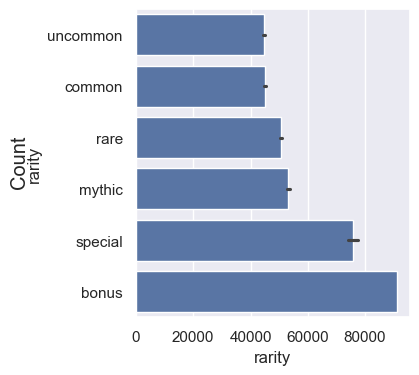

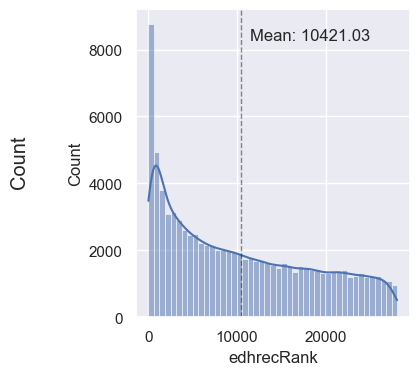

In [4]:
# General EDA presenting some of the data

#Plot variables
plot_variables(cards_data, ["rarity"], discrete=True)

plot_variables(cards_data, ["edhrecRank"], continuous=True)


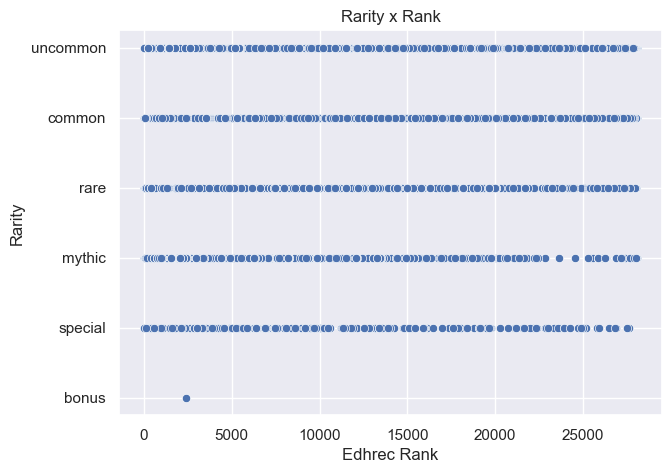

         edhrecRank  edhrecSaltiness     manaValue
count  89737.000000     66520.000000  89737.000000
mean   10421.032395         0.329156      3.153148
std     8301.618169         0.336558      1.894888
min        1.000000         0.010000      0.000000
25%     2870.000000         0.110000      2.000000
50%     8781.000000         0.220000      3.000000
75%    17123.000000         0.420000      4.000000
max    28071.000000         2.990000     16.000000


In [5]:
# Rank based on rarity

# Scatter - Show an good spread on 
plt.figure(figsize=(7,5))
sns.scatterplot(data=cards_data, x="edhrecRank", y="rarity")

plt.ylabel('Rarity')
plt.xlabel('Edhrec Rank')
plt.title('Rarity x Rank')
plt.show()
print(cards_data.describe())

In [6]:
# Plot KDE - Ignores non values
def plot_multiple_kdes_single_variable(data, variable, key_values, kde_column):
    for key in key_values:
        d = data[data[variable] == key]
        sns.kdeplot(d[kde_column], label=key, warn_singular=False)

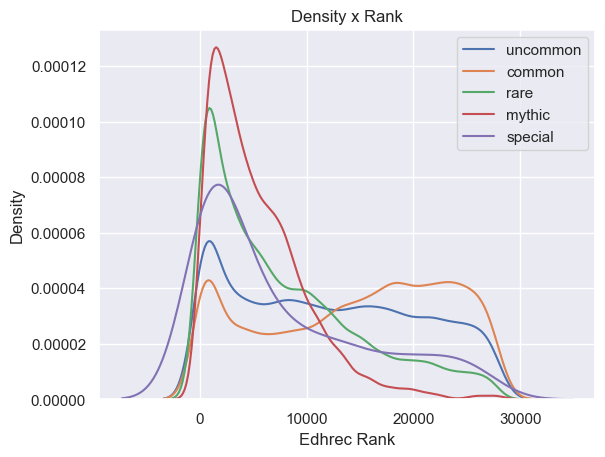

In [7]:

# Ploting rarity x rank 
#["uncomon", "common", "special", "rare", "mythic"]
labels = cards_data['rarity'].unique() 
plot_multiple_kdes_single_variable(cards_data, "rarity", labels, "edhrecRank")


plt.legend()
plt.ylabel('Density')
plt.xlabel('Edhrec Rank')
plt.title('Density x Rank')
plt.show()



# Card Prices

Starting to connect the information about prices on this notebook

## Info

What I learned from the data (allow to filter and have different analysis):
- Multiple Price providers
- Multi Currency
- Multi finish
- Multi gameAvailability
- Many outliers that make it difficult to analyze data

## Assumptions
- Prices in USD only
- Paper availability

In [133]:
# Analyzing only in dollards
card_prices.describe()

,price
count,432688.000000
mean,7.560411
std,214.903529
min,0.010000
25%,0.140000
50%,0.370000
75%,1.490000
max,65000.000000


In [134]:
def removeOutliers(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
 
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    outlier_free_list = [x for x in data[col] if ((x > lower_range) & (x < upper_range))]
    filtered_data = data.loc[data[col].isin(outlier_free_list)]
    return filtered_data

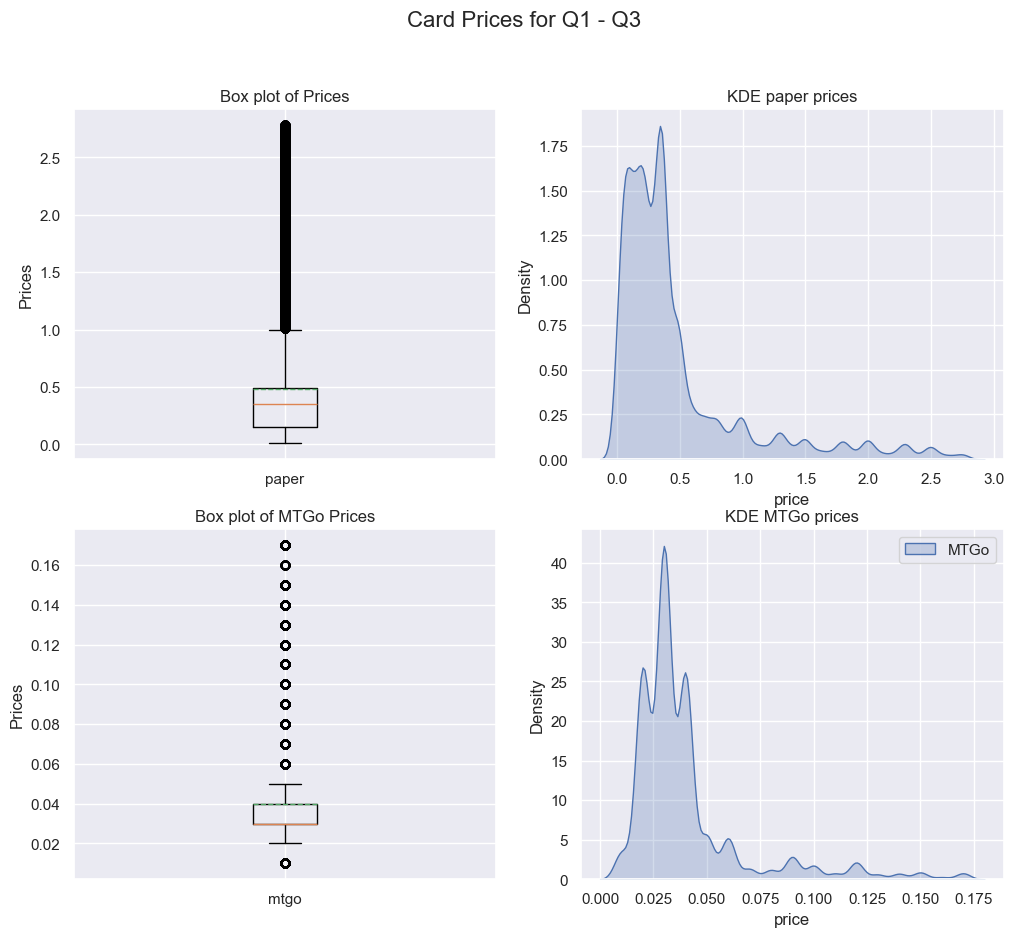

In [168]:

# Removing outliers to explore the data as a whole
d_paper = removeOutliers(card_prices[card_prices["gameAvailability"]=='paper'], 'price')
d_mtgo = removeOutliers(card_prices[card_prices["gameAvailability"]=='mtgo'], 'price')

fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize =(12, 10))

# Ploting Paper information
ax0.boxplot( d_paper['price'] , meanline=True, showmeans=True, tick_labels=['paper'])

ax0.set_title('Box plot of Prices')
ax0.set_ylabel('Prices')

sns.kdeplot(d_paper["price"], label='Paper Cards', fill= 'True', ax=ax1)


ax1.set_title('KDE paper prices')
ax1.set_ylabel('Density')


# Ploting MTGo information
ax2.boxplot(d_mtgo['price'] , meanline=True, showmeans=True, tick_labels=['mtgo'])

ax2.set_title('Box plot of MTGo Prices')
ax2.set_ylabel('Prices')

sns.kdeplot(d_mtgo["price"], label='MTGo', fill= 'True', ax=ax3)

ax3.set_title('KDE MTGo prices')
ax3.set_ylabel('Density')

# Ploting infor on Price Providers


fig.suptitle('Card Prices for Q1 - Q3', fontsize=16)
plt.legend()
plt.show() 

In [173]:
# DATA CLEANING

prices_no_outliers = removeOutliers(card_prices[card_prices["gameAvailability"]=='paper'], 'price')

# find rank for prices and reduzing sample size to only ranked cards
subset_rank_price = cards_data[cards_data["uuid"].isin(prices_no_outliers['uuid'])]
ranked_prices = prices_no_outliers[prices_no_outliers["uuid"].isin(subset_rank_price['uuid'])]

# merging card info$
price_rank_data = pd.merge(subset_rank_price,prices_no_outliers,on='uuid')

# RESULT MERGE DATA ARTISTS AND PRICES
print(price_rank_data.head())

         artist colorIdentity colors  edhrecRank  edhrecSaltiness finishes  \
0  Pete Venters             W      W     21862.0             0.14  nonfoil   
1  Pete Venters             W      W     21862.0             0.14  nonfoil   
2  Pete Venters             W      W     21862.0             0.14  nonfoil   
3  Pete Venters             W      W     21862.0             0.14     foil   
4   Volkan Baǵa             W      W     18028.0             0.36  nonfoil   

   hasFoil  hasNonFoil isReprint language  ...                     type  \
0    False        True      True  English  ...  Creature — Human Cleric   
1    False        True      True  English  ...  Creature — Human Cleric   
2    False        True      True  English  ...  Creature — Human Cleric   
3     True       False      True  English  ...  Creature — Human Cleric   
4    False        True      True  English  ...         Creature — Angel   

      types                                  uuid cardFinish currency  \
0  Crea

# Artist affect prices

- null hypothesis: artists have no impact on prices
- alt hypothesis: artists do have an impact

In [202]:
# DATA CLEANING

# Hypothesis H0: Artists have no impact on prices

# groups mean prices by artists
artists = price_rank_data['artist'].unique()

# Create a group of prices for each unique artist to performing a ANOVA test
artist_price_groups = [ price_rank_data[price_rank_data['artist'] == artist]['price'].to_numpy()
    for artist in artists if len(price_rank_data[price_rank_data['artist'] == artist]['price']) > 1 ]

# Removing Zero Variance artist prices
filtered_prices = [row for row in artist_price_groups if np.var(row) > 0]    


In [207]:
# Conduct the one-way ANOVA
t_stat, p_value = stats.f_oneway(*filtered_prices)

print("T-statistic: %.4f" % t_stat)
print("P-value: %.6f" % p_value);


T-statistic: 7.6670
P-value: 0.000000


## Intepretation

A higher F-statistic indicates that the group means are more different from each other than would be expected due to random chance.

In your case, an F-statistic of 7.6670 suggests that there is a significant amount of variance between the average prices of cards from different artists compared to the variance within each artist's prices.

A P-value of 0.000000 (effectively 0) means that there is a very low probability that the observed differences in average prices among artists occurred by chance.

## Conclusion
Given your results:

Since the P-value is significantly less than 0.05, you can reject the null hypothesis (H0), which states that artists have no impact on prices.

This indicates that there is a statistically significant difference in average card prices among different artists.

### Implications
**Artist Impact:** The results suggest that the artist associated with a card does influence its price, meaning that some artists may produce cards that are valued more highly in the market than others.

**Market Insights:** For collectors and sellers, understanding these differences can inform buying and pricing strategies.